In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf

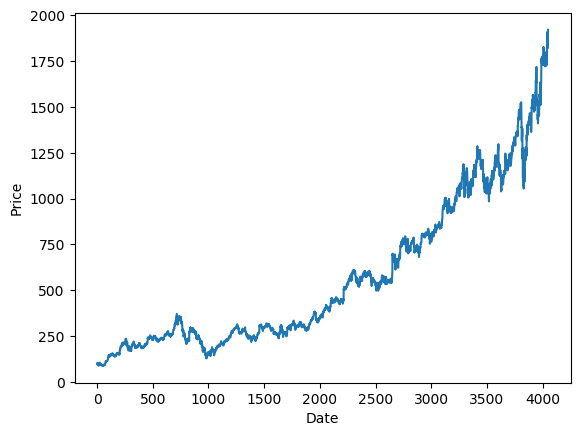

In [2]:
# Download stock data and plot the history diagram

import yfinance as yf
from datetime import datetime

stockName = "GOOGL"
stkTicker = yf.Ticker(stockName)
dataHist = stkTicker.history(start="2005-01-01", end=datetime.today().strftime('%Y-%m-%d'), interval = "1d")
dataClose = dataHist['Close'].to_numpy()
np.set_printoptions(threshold=np.inf)
plt.style.use("default")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(dataClose)

In [3]:
# Preprocess the historical data
# Format data array to LSTM
# -----------------------------------------------------------------------------------
#|  0-4044(4045)    dataClose, dataOpen, dataHist                                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|  1-4044(4044)    dataClose   dataset                                              |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         datasetTrain                           |   datasetTest                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         0-2446  xTrain             | 2447-2546 |                                  |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|       0-99     |     100-2546     yTrain      |                                  |
# -----------------------------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# ------------------x = Close--------------------
dataset = np.array(dataClose)

dataset = dataset.reshape(-1,1)

# ------------------With scaler--------------------
minmaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True)
_dataset = minmaxScaler.fit_transform(dataset)
print("The max =", minmaxScaler.data_max_,", the Min =",minmaxScaler.data_min_)

The max = [1919.11999512] , the Min = [87.58258057]


In [4]:
# Get train set and test set

sizeTrain = int(_dataset.size*0.63)
sizeTest = _dataset.size - sizeTrain
print("The length of data is:",_dataset.size, \
      "\nThe length of Training is:", sizeTrain, \
      "\nThe length of Testing is:", sizeTest)
_Train = _dataset[ : sizeTrain, : ]
_Test = _dataset[sizeTrain : , : ]

The length of data is: 4049 
The length of Training is: 2550 
The length of Testing is: 1499


In [5]:
# Format data array to LSTM
# -----------------------------------------------------------------------------------
#|  0-4044(4045)    dataClose, dataOpen, dataHist                                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|  0  |   1-4044(4044)                                                              |
# -----------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |    datasetTrain                           |   datasetTest                    |
#      ------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |    0-2446  xTrain             | 2447-2546 |                                  |
#      ------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |   0-99     |     100-2546     yTrain      |                                  |
#      ------------------------------------------------------------------------------

DIM_LSTM = 100

def formatData(dataSet,dimLSTM):
    X,Y = [],[]
    for i in range(dataSet.size - dimLSTM):
        X.append(dataSet[i : i+dimLSTM, : ])
        Y.append(dataSet[i + dimLSTM, : ])
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(-1,dimLSTM)
    Y = Y.reshape(-1,1)
    X = X.reshape(X.shape[0], X.shape[1],1)
    return X,Y
_xTrain, _yTrain = formatData(_Train, DIM_LSTM)
_xTest, _yTest = formatData(_Test, DIM_LSTM)
xTrain, yTrain = formatData(dataset[ : sizeTrain, : ], DIM_LSTM)
xTest, yTest = formatData(dataset[sizeTrain : , : ], DIM_LSTM)

In [6]:
# Build the model

import keras 
from keras.models import Sequential
from keras.layers import Dense, LSTM

UNIT_LSTM = 50
model = keras.Sequential()
model.add(LSTM(UNIT_LSTM, return_sequences = True, input_shape=(DIM_LSTM,1)))
model.add(LSTM(UNIT_LSTM, return_sequences = True))
model.add(LSTM(UNIT_LSTM))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model   
model.fit(_xTrain,_yTrain,validation_data=(_xTest,_yTest), epochs=10, batch_size=64, verbose =1)

Epoch 1/10
39/39 [==============================] - 22s 365ms/step - loss: 0.0052 - val_loss: 0.0010
Epoch 2/10
39/39 [==============================] - 11s 291ms/step - loss: 1.2949e-04 - val_loss: 8.3552e-04
Epoch 3/10
39/39 [==============================] - 11s 290ms/step - loss: 9.0615e-05 - val_loss: 8.4989e-04
Epoch 4/10
39/39 [==============================] - 11s 293ms/step - loss: 7.2666e-05 - val_loss: 7.7267e-04
Epoch 5/10
39/39 [==============================] - 12s 299ms/step - loss: 7.5664e-05 - val_loss: 8.9344e-04
Epoch 6/10
39/39 [==============================] - 11s 295ms/step - loss: 7.1122e-05 - val_loss: 7.8518e-04
Epoch 7/10
13/39 [=========>....................] - ETA: 6s - loss: 6.4740e-05

In [10]:
# Make predictions

from sklearn.metrics import mean_squared_error

_predTrain = model.predict(_xTrain)
_predTest= model.predict(_xTest)
predTrain = minmaxScaler.inverse_transform(_predTrain)
predTest = minmaxScaler.inverse_transform(_predTest)
mean_squared_error(predTrain,yTrain)

253.37282245321342

In [11]:
gain =1
predTrain = predTrain.flatten()
for i in range(predTrain.size-1):
    if predTrain[i+1] > yTrain[i]:
        gain = gain * (yTrain[i+1]/yTrain[i])
        print(i, "\tCurrClose:%.02f" %yTrain[i], \
                 "\tNextClose:%.02f" %yTrain[i+1], \
                 "\tPredNextClose%+.02f" %predTrain[i+1], \
                 "\tLongTermGain%+.02f" %(yTrain[i+1]/yTrain[0]), \
                 "\tTotalGain%+.02f" %gain)
print("\n\n\nFinal gain comparasion:\t",gain,"rather than Long-Term-Gain",yTrain[predTrain.size-1]/yTrain[0])

10 	CurrClose:141.39 	NextClose:141.52 	PredNextClose+142.29 	LongTermGain+1.09 	TotalGain+1.00
11 	CurrClose:141.52 	NextClose:139.31 	PredNextClose+143.86 	LongTermGain+1.07 	TotalGain+0.99
12 	CurrClose:139.31 	NextClose:137.54 	PredNextClose+145.18 	LongTermGain+1.06 	TotalGain+0.97
13 	CurrClose:137.54 	NextClose:138.86 	PredNextClose+146.22 	LongTermGain+1.07 	TotalGain+0.98
14 	CurrClose:138.86 	NextClose:140.29 	PredNextClose+146.99 	LongTermGain+1.08 	TotalGain+0.99
15 	CurrClose:140.29 	NextClose:143.49 	PredNextClose+147.52 	LongTermGain+1.11 	TotalGain+1.01
16 	CurrClose:143.49 	NextClose:144.06 	PredNextClose+147.89 	LongTermGain+1.11 	TotalGain+1.02
17 	CurrClose:144.06 	NextClose:144.79 	PredNextClose+148.15 	LongTermGain+1.12 	TotalGain+1.02
18 	CurrClose:144.79 	NextClose:145.00 	PredNextClose+148.36 	LongTermGain+1.12 	TotalGain+1.03
19 	CurrClose:145.00 	NextClose:148.77 	PredNextClose+148.56 	LongTermGain+1.15 	TotalGain+1.05
20 	CurrClose:148.77 	NextClose:152.20 	

369 	CurrClose:237.01 	NextClose:240.76 	PredNextClose+244.30 	LongTermGain+1.86 	TotalGain+1.58
370 	CurrClose:240.76 	NextClose:244.89 	PredNextClose+244.87 	LongTermGain+1.89 	TotalGain+1.60
371 	CurrClose:244.89 	NextClose:246.21 	PredNextClose+245.38 	LongTermGain+1.90 	TotalGain+1.61
375 	CurrClose:247.77 	NextClose:255.08 	PredNextClose+247.90 	LongTermGain+1.97 	TotalGain+1.66
379 	CurrClose:242.62 	NextClose:244.99 	PredNextClose+252.04 	LongTermGain+1.89 	TotalGain+1.68
380 	CurrClose:244.99 	NextClose:242.57 	PredNextClose+252.98 	LongTermGain+1.87 	TotalGain+1.66
381 	CurrClose:242.57 	NextClose:242.65 	PredNextClose+253.73 	LongTermGain+1.87 	TotalGain+1.66
382 	CurrClose:242.65 	NextClose:240.64 	PredNextClose+254.25 	LongTermGain+1.85 	TotalGain+1.65
383 	CurrClose:240.64 	NextClose:242.67 	PredNextClose+254.52 	LongTermGain+1.87 	TotalGain+1.66
384 	CurrClose:242.67 	NextClose:243.74 	PredNextClose+254.56 	LongTermGain+1.88 	TotalGain+1.67
385 	CurrClose:243.74 	NextClo

813 	CurrClose:245.50 	NextClose:242.74 	PredNextClose+249.76 	LongTermGain+1.87 	TotalGain+1.24
814 	CurrClose:242.74 	NextClose:243.51 	PredNextClose+250.82 	LongTermGain+1.88 	TotalGain+1.24
815 	CurrClose:243.51 	NextClose:245.54 	PredNextClose+251.71 	LongTermGain+1.89 	TotalGain+1.25
816 	CurrClose:245.54 	NextClose:241.75 	PredNextClose+252.43 	LongTermGain+1.86 	TotalGain+1.23
817 	CurrClose:241.75 	NextClose:237.32 	PredNextClose+252.94 	LongTermGain+1.83 	TotalGain+1.21
818 	CurrClose:237.32 	NextClose:234.52 	PredNextClose+253.17 	LongTermGain+1.81 	TotalGain+1.19
819 	CurrClose:234.52 	NextClose:237.13 	PredNextClose+253.11 	LongTermGain+1.83 	TotalGain+1.21
820 	CurrClose:237.13 	NextClose:231.88 	PredNextClose+252.76 	LongTermGain+1.79 	TotalGain+1.18
821 	CurrClose:231.88 	NextClose:232.86 	PredNextClose+252.14 	LongTermGain+1.79 	TotalGain+1.18
822 	CurrClose:232.86 	NextClose:232.44 	PredNextClose+251.28 	LongTermGain+1.79 	TotalGain+1.18
823 	CurrClose:232.44 	NextClo

1161 	CurrClose:304.43 	NextClose:297.35 	PredNextClose+313.57 	LongTermGain+2.29 	TotalGain+1.36
1162 	CurrClose:297.35 	NextClose:301.31 	PredNextClose+314.54 	LongTermGain+2.32 	TotalGain+1.37
1163 	CurrClose:301.31 	NextClose:300.86 	PredNextClose+315.21 	LongTermGain+2.32 	TotalGain+1.37
1164 	CurrClose:300.86 	NextClose:295.54 	PredNextClose+315.57 	LongTermGain+2.28 	TotalGain+1.35
1165 	CurrClose:295.54 	NextClose:293.84 	PredNextClose+315.59 	LongTermGain+2.27 	TotalGain+1.34
1166 	CurrClose:293.84 	NextClose:295.22 	PredNextClose+315.26 	LongTermGain+2.28 	TotalGain+1.35
1167 	CurrClose:295.22 	NextClose:290.29 	PredNextClose+314.62 	LongTermGain+2.24 	TotalGain+1.32
1168 	CurrClose:290.29 	NextClose:294.10 	PredNextClose+313.69 	LongTermGain+2.27 	TotalGain+1.34
1169 	CurrClose:294.10 	NextClose:290.50 	PredNextClose+312.54 	LongTermGain+2.24 	TotalGain+1.32
1170 	CurrClose:290.50 	NextClose:291.78 	PredNextClose+311.23 	LongTermGain+2.25 	TotalGain+1.33
1171 	CurrClose:291.

1438 	CurrClose:308.53 	NextClose:312.56 	PredNextClose+315.27 	LongTermGain+2.41 	TotalGain+1.51
1439 	CurrClose:312.56 	NextClose:314.39 	PredNextClose+315.16 	LongTermGain+2.42 	TotalGain+1.52
1440 	CurrClose:314.39 	NextClose:312.39 	PredNextClose+315.22 	LongTermGain+2.41 	TotalGain+1.51
1441 	CurrClose:312.39 	NextClose:312.42 	PredNextClose+315.44 	LongTermGain+2.41 	TotalGain+1.51
1442 	CurrClose:312.42 	NextClose:312.94 	PredNextClose+315.79 	LongTermGain+2.41 	TotalGain+1.51
1443 	CurrClose:312.94 	NextClose:315.36 	PredNextClose+316.24 	LongTermGain+2.43 	TotalGain+1.52
1444 	CurrClose:315.36 	NextClose:305.41 	PredNextClose+316.78 	LongTermGain+2.35 	TotalGain+1.47
1445 	CurrClose:305.41 	NextClose:305.97 	PredNextClose+317.30 	LongTermGain+2.36 	TotalGain+1.48
1446 	CurrClose:305.97 	NextClose:304.71 	PredNextClose+317.71 	LongTermGain+2.35 	TotalGain+1.47
1447 	CurrClose:304.71 	NextClose:305.33 	PredNextClose+317.98 	LongTermGain+2.35 	TotalGain+1.47
1448 	CurrClose:305.

1703 	CurrClose:311.51 	NextClose:310.94 	PredNextClose+312.70 	LongTermGain+2.40 	TotalGain+1.23
1704 	CurrClose:310.94 	NextClose:307.43 	PredNextClose+313.35 	LongTermGain+2.37 	TotalGain+1.21
1705 	CurrClose:307.43 	NextClose:302.78 	PredNextClose+313.98 	LongTermGain+2.33 	TotalGain+1.19
1706 	CurrClose:302.78 	NextClose:303.70 	PredNextClose+314.51 	LongTermGain+2.34 	TotalGain+1.20
1707 	CurrClose:303.70 	NextClose:303.87 	PredNextClose+314.90 	LongTermGain+2.34 	TotalGain+1.20
1708 	CurrClose:303.87 	NextClose:300.43 	PredNextClose+315.15 	LongTermGain+2.32 	TotalGain+1.19
1709 	CurrClose:300.43 	NextClose:302.88 	PredNextClose+315.21 	LongTermGain+2.33 	TotalGain+1.19
1710 	CurrClose:302.88 	NextClose:309.20 	PredNextClose+315.11 	LongTermGain+2.38 	TotalGain+1.22
1711 	CurrClose:309.20 	NextClose:308.30 	PredNextClose+314.96 	LongTermGain+2.38 	TotalGain+1.22
1712 	CurrClose:308.30 	NextClose:310.88 	PredNextClose+314.79 	LongTermGain+2.40 	TotalGain+1.23
1713 	CurrClose:310.

2055 	CurrClose:443.12 	NextClose:441.58 	PredNextClose+467.83 	LongTermGain+3.40 	TotalGain+1.45
2056 	CurrClose:441.58 	NextClose:445.91 	PredNextClose+467.44 	LongTermGain+3.44 	TotalGain+1.47
2057 	CurrClose:445.91 	NextClose:444.32 	PredNextClose+466.76 	LongTermGain+3.42 	TotalGain+1.46
2058 	CurrClose:444.32 	NextClose:452.56 	PredNextClose+465.84 	LongTermGain+3.49 	TotalGain+1.49
2059 	CurrClose:452.56 	NextClose:453.74 	PredNextClose+464.87 	LongTermGain+3.50 	TotalGain+1.49
2060 	CurrClose:453.74 	NextClose:452.95 	PredNextClose+463.96 	LongTermGain+3.49 	TotalGain+1.49
2061 	CurrClose:452.95 	NextClose:448.73 	PredNextClose+463.18 	LongTermGain+3.46 	TotalGain+1.47
2062 	CurrClose:448.73 	NextClose:445.77 	PredNextClose+462.54 	LongTermGain+3.44 	TotalGain+1.46
2063 	CurrClose:445.77 	NextClose:446.78 	PredNextClose+461.98 	LongTermGain+3.44 	TotalGain+1.47
2064 	CurrClose:446.78 	NextClose:445.65 	PredNextClose+461.48 	LongTermGain+3.44 	TotalGain+1.46
2065 	CurrClose:445.

2410 	CurrClose:532.30 	NextClose:538.77 	PredNextClose+538.75 	LongTermGain+4.15 	TotalGain+1.85
2415 	CurrClose:535.28 	NextClose:530.66 	PredNextClose+536.07 	LongTermGain+4.09 	TotalGain+1.83
2416 	CurrClose:530.66 	NextClose:529.55 	PredNextClose+537.07 	LongTermGain+4.08 	TotalGain+1.83
2417 	CurrClose:529.55 	NextClose:519.46 	PredNextClose+538.24 	LongTermGain+4.00 	TotalGain+1.79
2418 	CurrClose:519.46 	NextClose:506.64 	PredNextClose+539.33 	LongTermGain+3.91 	TotalGain+1.75
2419 	CurrClose:506.64 	NextClose:505.15 	PredNextClose+540.05 	LongTermGain+3.89 	TotalGain+1.74
2420 	CurrClose:505.15 	NextClose:506.91 	PredNextClose+540.23 	LongTermGain+3.91 	TotalGain+1.75
2421 	CurrClose:506.91 	NextClose:500.72 	PredNextClose+539.86 	LongTermGain+3.86 	TotalGain+1.73
2422 	CurrClose:500.72 	NextClose:497.06 	PredNextClose+538.89 	LongTermGain+3.83 	TotalGain+1.72
2423 	CurrClose:497.06 	NextClose:501.80 	PredNextClose+537.33 	LongTermGain+3.87 	TotalGain+1.73
2424 	CurrClose:501.

In [12]:
gain =1
predTest = predTest.flatten()
for i in range(predTest.size-1):
    if predTest[i+1] > yTest[i]:
        gain = gain * (yTest[i+1]/yTest[i])
        print(i, "\tCurrClose:%.02f" %yTest[i], \
                 "\tNextClose:%.02f" %yTest[i+1], \
                 "\tPredGain%+.02f" %predTest[i+1], \
                 "\tLongTermGain%+.02f" %(yTest[i+1]/yTest[0]), \
                 "\tTotalGain%+.02f" %gain)
print("\n\n\nFinal gain comparasion:\t",gain,"rather than Long-Term-Gain",yTest[predTest.size-1]/yTest[0])

12 	CurrClose:657.50 	NextClose:664.72 	PredGain+671.32 	LongTermGain+1.14 	TotalGain+1.01
13 	CurrClose:664.72 	NextClose:661.28 	PredGain+677.34 	LongTermGain+1.13 	TotalGain+1.01
14 	CurrClose:661.28 	NextClose:673.29 	PredGain+682.04 	LongTermGain+1.15 	TotalGain+1.02
15 	CurrClose:673.29 	NextClose:670.15 	PredGain+685.68 	LongTermGain+1.15 	TotalGain+1.02
16 	CurrClose:670.15 	NextClose:664.39 	PredGain+688.42 	LongTermGain+1.14 	TotalGain+1.01
17 	CurrClose:664.39 	NextClose:663.14 	PredGain+690.36 	LongTermGain+1.14 	TotalGain+1.01
18 	CurrClose:663.14 	NextClose:690.30 	PredGain+691.58 	LongTermGain+1.18 	TotalGain+1.05
19 	CurrClose:690.30 	NextClose:691.47 	PredGain+692.49 	LongTermGain+1.18 	TotalGain+1.05
20 	CurrClose:691.47 	NextClose:686.51 	PredGain+693.37 	LongTermGain+1.18 	TotalGain+1.04
21 	CurrClose:686.51 	NextClose:689.37 	PredGain+694.32 	LongTermGain+1.18 	TotalGain+1.05
22 	CurrClose:689.37 	NextClose:694.11 	PredGain+695.41 	LongTermGain+1.19 	TotalGain+1.06

405 	CurrClose:851.36 	NextClose:851.00 	PredGain+853.49 	LongTermGain+1.46 	TotalGain+1.17
406 	CurrClose:851.00 	NextClose:847.81 	PredGain+855.06 	LongTermGain+1.45 	TotalGain+1.16
407 	CurrClose:847.81 	NextClose:849.67 	PredGain+856.80 	LongTermGain+1.46 	TotalGain+1.16
408 	CurrClose:849.67 	NextClose:844.93 	PredGain+858.63 	LongTermGain+1.45 	TotalGain+1.16
409 	CurrClose:844.93 	NextClose:856.75 	PredGain+860.41 	LongTermGain+1.47 	TotalGain+1.17
410 	CurrClose:856.75 	NextClose:849.85 	PredGain+862.19 	LongTermGain+1.46 	TotalGain+1.16
411 	CurrClose:849.85 	NextClose:849.08 	PredGain+863.90 	LongTermGain+1.45 	TotalGain+1.16
412 	CurrClose:849.08 	NextClose:847.27 	PredGain+865.46 	LongTermGain+1.45 	TotalGain+1.16
413 	CurrClose:847.27 	NextClose:851.15 	PredGain+866.83 	LongTermGain+1.46 	TotalGain+1.17
414 	CurrClose:851.15 	NextClose:853.64 	PredGain+868.00 	LongTermGain+1.46 	TotalGain+1.17
415 	CurrClose:853.64 	NextClose:857.84 	PredGain+869.03 	LongTermGain+1.47 	Tot

770 	CurrClose:1238.16 	NextClose:1237.67 	PredGain+1247.71 	LongTermGain+2.12 	TotalGain+1.48
771 	CurrClose:1237.67 	NextClose:1255.84 	PredGain+1250.84 	LongTermGain+2.15 	TotalGain+1.50
775 	CurrClose:1252.51 	NextClose:1248.64 	PredGain+1259.02 	LongTermGain+2.14 	TotalGain+1.49
776 	CurrClose:1248.64 	NextClose:1258.14 	PredGain+1260.43 	LongTermGain+2.15 	TotalGain+1.51
777 	CurrClose:1258.14 	NextClose:1232.22 	PredGain+1261.64 	LongTermGain+2.11 	TotalGain+1.48
778 	CurrClose:1232.22 	NextClose:1224.06 	PredGain+1262.40 	LongTermGain+2.10 	TotalGain+1.47
779 	CurrClose:1224.06 	NextClose:1215.85 	PredGain+1262.53 	LongTermGain+2.08 	TotalGain+1.46
780 	CurrClose:1215.85 	NextClose:1221.95 	PredGain+1261.86 	LongTermGain+2.09 	TotalGain+1.46
781 	CurrClose:1221.95 	NextClose:1217.41 	PredGain+1260.46 	LongTermGain+2.08 	TotalGain+1.46
782 	CurrClose:1217.41 	NextClose:1221.75 	PredGain+1258.38 	LongTermGain+2.09 	TotalGain+1.46
783 	CurrClose:1221.75 	NextClose:1221.16 	PredGai

1147 	CurrClose:1445.41 	NextClose:1446.05 	PredGain+1453.89 	LongTermGain+2.48 	TotalGain+2.19
1148 	CurrClose:1446.05 	NextClose:1475.97 	PredGain+1454.10 	LongTermGain+2.53 	TotalGain+2.24
1160 	CurrClose:1419.86 	NextClose:1386.32 	PredGain+1482.96 	LongTermGain+2.37 	TotalGain+2.18
1161 	CurrClose:1386.32 	NextClose:1390.47 	PredGain+1483.20 	LongTermGain+2.38 	TotalGain+2.19
1162 	CurrClose:1390.47 	NextClose:1314.95 	PredGain+1480.96 	LongTermGain+2.25 	TotalGain+2.07
1163 	CurrClose:1314.95 	NextClose:1339.25 	PredGain+1475.55 	LongTermGain+2.29 	TotalGain+2.11
1164 	CurrClose:1339.25 	NextClose:1386.32 	PredGain+1467.26 	LongTermGain+2.37 	TotalGain+2.18
1165 	CurrClose:1386.32 	NextClose:1337.72 	PredGain+1457.09 	LongTermGain+2.29 	TotalGain+2.11
1166 	CurrClose:1337.72 	NextClose:1381.60 	PredGain+1445.39 	LongTermGain+2.37 	TotalGain+2.18
1167 	CurrClose:1381.60 	NextClose:1314.76 	PredGain+1433.14 	LongTermGain+2.25 	TotalGain+2.07
1168 	CurrClose:1314.76 	NextClose:1295.